# Проект №3. О вкусной и здоровой пище 

## Цель проекта :

Построение модели, которая предсказывает рейтинг ресторана, чтто бы понять какие рестораны накручивают свой рейтинг.

## Описание датасета:    

Данный датасет содержить инфорсацию о 40000 ресторанов Европы.  
Описание признаков:  
Restaurant_id — идентификационный номер ресторана / сети ресторанов;  
City — город, в котором находится ресторан;  
Cuisine Style — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;  
Ranking — место, которое занимает данный ресторан среди всех ресторанов своего города;  
Rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);  
Price Range — диапазон цен в ресторане;  
Number of Reviews — количество отзывов о ресторане;  
Reviews — данные о двух отзывах, которые отображаются на сайте ресторана;  
URL_TA — URL страницы ресторана на TripAdvosor;  
ID_TA — идентификатор ресторана в базе данных TripAdvisor.  

## Загрузка Pandas и очистка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split  
import re
from collections import Counter
import requests
from bs4 import BeautifulSoup
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import combinations
from scipy.stats import ttest_ind
import statsmodels.api as sm

In [2]:
from scipy import stats

In [3]:
df = pd.read_csv('main_task.csv')
pd.set_option('display.max_colwidth', None)

In [4]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [5]:
# Ваш код по очистке данных и генерации новых признаков
# При необходимости добавьте ячейки

# Конвертация уровня стоимости
def conv_price(x):
    d = {
        '$$ - $$$':2,
        '$': 1,
        '$$$$':3
    }
    if x in d.keys():
        return d[x]
    elif pd.isnull(x):
        return float('NaN')
    else:
        return float('NaN')
# Конвертация Cuisine Style
def conv_cuisine(x):
    lx=re.compile('\[.*\]')
    if type(x)==str and lx.fullmatch(x):
        lst=eval(x)
        return lst
    #elif pd.isnull(x):
    else:
        return ['NaN']


# 0. Проведём первичный анализ датасета

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


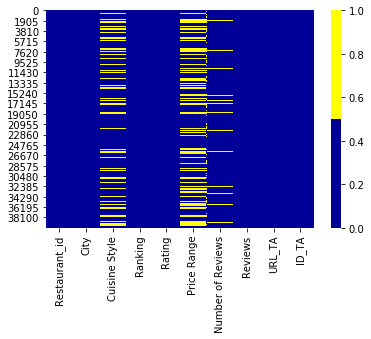

In [7]:
#  Визуализируем пропущенные значения с помощью тепловой карты.
colours = ['#000099', '#ffff00'] # определяем цвета, желтый - пропущенные данные, синий - не пропущенные 
sns.heatmap(df.isnull(), cmap=sns.color_palette(colours))

In [8]:
# Составим список долей отсутствующих записей для каждого признака в процентах
for col in df:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

Restaurant_id - 0.0%
City - 0.0%
Cuisine Style - 23.0%
Ranking - 0.0%
Rating - 0.0%
Price Range - 35.0%
Number of Reviews - 6.0%
Reviews - 0.0%
URL_TA - 0.0%
ID_TA - 0.0%


In [9]:
#  То же, но в реальном выражение
pd.isnull(df).sum()

Restaurant_id            0
City                     0
Cuisine Style         9283
Ranking                  0
Rating                   0
Price Range          13886
Number of Reviews     2543
Reviews                  0
URL_TA                   0
ID_TA                    0
dtype: int64

Больше всего пропускав в колонках Cuisine Style (23.0%, 9283),
Price Range(35.0%, 13886). Так же есть пропуски в колонке Number of Reviews (6.0%, 2543)

In [10]:
df1= df.drop(['City', 'Reviews', 'URL_TA', 'ID_TA', 'Cuisine Style', 'Price Range'], axis=1)

In [11]:
df1.describe()

Ranking        Rating  Number of Reviews
count  40000.000000  40000.000000       37457.000000
mean    3676.028525      3.993037         124.825480
std     3708.749567      0.668417         295.666352
min        1.000000      1.000000           2.000000
25%      973.000000      3.500000           9.000000
50%     2285.000000      4.000000          33.000000
75%     5260.000000      4.500000         115.000000
max    16444.000000      5.000000        9660.000000

In [12]:
mean = df1['Number of Reviews'].mean()
df1['Number of Reviews'] = df1['Number of Reviews'].fillna(mean)
df1.describe()

Ranking        Rating  Number of Reviews
count  40000.000000  40000.000000       40000.000000
mean    3676.028525      3.993037         124.825480
std     3708.749567      0.668417         286.113292
min        1.000000      1.000000           2.000000
25%      973.000000      3.500000          10.000000
50%     2285.000000      4.000000          38.000000
75%     5260.000000      4.500000         124.825480
max    16444.000000      5.000000        9660.000000

## 1. Начнём со столбца ID_TA

In [13]:
df = pd.read_csv('main_task.csv')
pd.set_option('display.max_colwidth', None)

In [14]:
'''Предположим, что Tripadvisor назначает индификаторы в порядке добавления ресторана в систему,
 переведем параметр в числовой и будет использовать в расчетной модели'''
df['ID_TA'] = df['ID_TA'].apply(lambda x: int(x[1:]))
df.head(3)

Restaurant_id       City  \
0       id_5569      Paris   
1       id_1535  Stockholm   
2        id_352     London   

                                                                                            Cuisine Style  \
0                                                                 ['European', 'French', 'International']   
1                                                                                                     NaN   
2  ['Japanese', 'Sushi', 'Asian', 'Grill', 'Vegetarian Friendly', 'Vegan Options', 'Gluten Free Options']   

   Ranking  Rating Price Range  Number of Reviews  \
0   5570.0     3.5    $$ - $$$              194.0   
1   1537.0     4.0         NaN               10.0   
2    353.0     4.5        $$$$              688.0   

                                                                                     Reviews  \
0  [['Good food at your doorstep', 'A good hotel restaurant'], ['12/31/2017', '11/20/2017']]   
1              [['Unique cuisine', 'Delicious Nepalese food'], ['07/06/2017', '06/19/2016']]   
2               [['Catch up with friends', 'Not exceptional'], ['01/08/2018', '01/06/2018']]   

                                                                         URL_TA  \
0   /Restaurant_Review-g187147-d1912643-Reviews-R_Yves-Paris_Ile_de_France.html   
1       /Restaurant_Review-g189852-d7992032-Reviews-Buddha_Nepal-Stockholm.html   
2  /Restaurant_Review-g186338-d8632781-Reviews-ROKA_Mayfair-London_England.html   

     ID_TA  
0  1912643  
1  7992032  
2  8632781

## 2. Обработаем признак диапазон цен в ресторане:

In [15]:
# в переменной очень много пропусков 13886 (35%)
# сохраним информацию о пропусках чтобы не потерять
df['NaN_Price Range'] = pd.isna(df['Price Range']).astype('float64') 

In [16]:
# Посчитаем количество ресторанов в зависимости от уровня цен
df['Price Range'].value_counts(dropna = False)   

$$ - $$$    18412
NaN         13886
$            6279
$$$$         1423
Name: Price Range, dtype: int64

In [17]:
# Заменим все пропуски (NaN) на моду
df['Price Range'].fillna('$$ - $$$', inplace = True)
df['Price Range'].value_counts(dropna = False)   
df ['Price Range'].head(3)

0    $$ - $$$
1    $$ - $$$
2        $$$$
Name: Price Range, dtype: object

In [18]:
#Конвектируем ценны в цифры где $=1, $$ - $$$ =2, $$$$ =3
df['Price Range'] =  df['Price Range'].apply(conv_price)
# И преабразуем значения в категории 
df ['Price Range'].head(3)

0    2
1    2
2    3
Name: Price Range, dtype: int64

count    40000.000000
mean         1.878600
std          0.421683
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          3.000000
Name: Price Range, dtype: float64

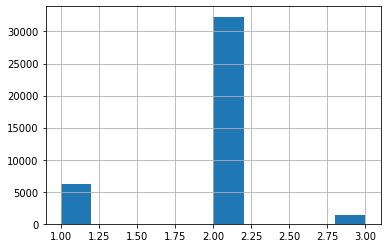

In [19]:
# проверим полученный критерий
df['Price Range'].hist()
df['Price Range'].describe()

Резюме - Price Range: в переменной очень много пропусков 13886 (35%). Чтобы не потерять информацию о пропусках создан новый критерий - 'NaN_Price Range'. Также создан новый признак числового кодирования цены - 'Price_Range' (низкая цена - 1, средняя цена -2 , высокая цена - 3). Пропуски заполнили модой - средней ценой (двойкой).

## 3. Обработаем признак кухни представленные в ресторане:

In [20]:
# в переменной 9283 (23%) пропущенных значений 
# сохраним эту информацию
df['NAN_Cuisine Style'] = pd.isna(df['Cuisine Style']).astype('float64') 

In [21]:
# заполним пропуски значением 'Other'
df['Cuisine Style'] = df['Cuisine Style'].fillna("['Other']")

In [22]:
# Уберём все лишнии знаки из списка кухон. 
df['Cuisine Style'] = df['Cuisine Style'].fillna('None') # меняем NaN на null
df['Cuisine Style'] = df['Cuisine Style'].str.replace('[','') # убираем [
df['Cuisine Style'] = df['Cuisine Style'].str.replace(']','') # убираем ]
df['Cuisine Style'] = df['Cuisine Style'].str.replace("'", '') # убираем''
df['Cuisine Style'] = df['Cuisine Style'].str.replace(' ', '') # убираем пробелы
df['Cuisine Style'].head(5)

0                                                   European,French,International
1                                                                           Other
2    Japanese,Sushi,Asian,Grill,VegetarianFriendly,VeganOptions,GlutenFreeOptions
3                                                                           Other
4                                       German,CentralEuropean,VegetarianFriendly
Name: Cuisine Style, dtype: object

In [23]:
# Посчитаем, сколько раз каждая кухня представлена в ДФ 
cuisine_count= pd.DataFrame(df['Cuisine Style'].str.split(',').tolist()).stack().value_counts() # Получаем объект series со списком кухонь
cuisine_count = pd.DataFrame({'Cuisine':cuisine_count.index, 'Count':cuisine_count.values}) # Переводим series в dataframe
cuisine_count.head(3)

Cuisine  Count
0  VegetarianFriendly  11189
1            European  10060
2               Other   9283

In [24]:
# Добавим признак количество кухонь в ресторане
df['Cuisine Count'] = df['Cuisine Style'].apply(lambda x: len(str(x).split(',')))
#Посчитаем среднее количество кухонь в датасете
round(df[['Cuisine Count']].mean(axis=0))

Cuisine Count    3.0
dtype: float64

In [25]:
# Создаю список кухонь, представленных единожды в ДФ
unique_cuisine = list(cuisine_count[cuisine_count['Count'] == 1]['Cuisine'])
unique_cuisine

['Burmese', 'Salvadoran', 'Latvian', 'Xinjiang', 'Yunnan']

In [26]:
#Создаю функцию определения наличия уникальной кухни в ресторане
def Unique_Cuisine(data):
    result = 0
    for cuisine in unique_cuisine:
        if cuisine in data:
            result = 1
    return result
     
#Добавляю столбец параметов уникальных кухонь    
df['Unique Cuisine'] = df['Cuisine Style'].apply(lambda x: Unique_Cuisine(x))
df[df['Unique Cuisine'] == 1]

Restaurant_id       City  \
10858       id_1965     Madrid   
14743       id_1533  Barcelona   
22130       id_6375      Paris   
22961       id_7467     London   
37919       id_1129   Budapest   

                                                     Cuisine Style  Ranking  \
10858             Mexican,Latin,Salvadoran,CentralAmerican,Spanish   1967.0   
14743            Asian,Thai,Yunnan,VegetarianFriendly,VeganOptions   1534.0   
22130                                             Chinese,Xinjiang   6376.0   
22961                                   Chinese,Asian,Thai,Burmese   7476.0   
37919  Mexican,American,European,Latvian,EasternEuropean,Hungarian   1130.0   

       Rating  Price Range  Number of Reviews  \
10858     4.0            2              280.0   
14743     4.0            2              185.0   
22130     4.0            2               41.0   
22961     5.0            1                5.0   
37919     5.0            1                5.0   

                                                                                                    Reviews  \
10858                        [['Excellent flamenco show', 'Average mexican'], ['04/08/2017', '10/30/2017']]   
14743                                [['Amaaaaaaazing', 'Fusion of tastes.'], ['06/26/2017', '10/06/2017']]   
22130        [['Awsome and highly recommended', 'This brings back memories'], ['04/18/2017', '10/01/2016']]   
22961  [['Have to go back again soon - delicious foo...', 'Wonderful food!'], ['12/13/2017', '11/04/2017']]   
37919                                 [['What a great idea', 'Hit and miss'], ['03/01/2017', '07/17/2017']]   

                                                                                                           URL_TA  \
10858                                       /Restaurant_Review-g187514-d6656786-Reviews-Sombrero_Azul-Madrid.html   
14743                                  /Restaurant_Review-g187497-d6959209-Reviews-Banna-Barcelona_Catalonia.html   
22130  /Restaurant_Review-g187147-d5017904-Reviews-Muqam_Restaurant_Specialite_Ouighoure-Paris_Ile_de_France.html   
22961                             /Restaurant_Review-g186338-d12870156-Reviews-Vera_s_Kitchen-London_England.html   
37919                 /Restaurant_Review-g274887-d11864784-Reviews-Food_Truck_Udvar-Budapest_Central_Hungary.html   

          ID_TA  NaN_Price Range  NAN_Cuisine Style  Cuisine Count  \
10858   6656786              0.0                0.0              5   
14743   6959209              0.0                0.0              5   
22130   5017904              0.0                0.0              2   
22961  12870156              0.0                0.0              4   
37919  11864784              0.0                0.0              6   

       Unique Cuisine  
10858               1  
14743               1  
22130               1  
22961               1  
37919               1

In [27]:
# Посчитаем сколько ресторанов имеют уникальную кухню
df['Unique Cuisine'].value_counts(dropna =True)   

0    39995
1        5
Name: Unique Cuisine, dtype: int64

count    40000.000000
mean         2.622400
std          1.817292
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         21.000000
Name: Cuisine Count, dtype: float64

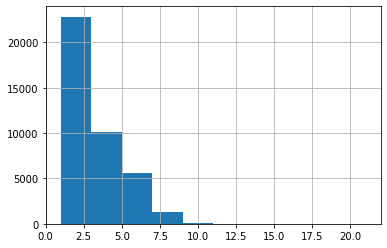

In [28]:
# проверим полученный критерий
df['Cuisine Count'].hist()
df['Cuisine Count'].describe()

Резюме - Cuisine Style: Много пропусков 9283 (23.2%). Чтобы сохранить эту информацию сформирован новый признак 'NAN_Cuisine Style'. По уникальным кухням составлен признак - 'Unique Cuisine'. Кроме этого, после обработки, добавлен критерий количества типов кухонь в ресторане ''Cuisine Count'. В новом признаке выбросов нет. В исходном критерии все типы кухонь были заполнены, [] пустых списков не было.

## 3. Обработаем колонки по отзывам

###  3.1 Обработаем колонку Number of Reviews	

In [29]:
# в переменной 2543 (6%) пропущенных значений 
# сохраним эту информацию
df['NAN_Number of Reviews'] = pd.isna(df['Number of Reviews']).astype('float64')

In [30]:
# Поскольку для всех ресторанов представлены отзывы (параметры URL_TA и ID_TA не имеют пропусков),
# то недостающие значения параметра 'Number of Reviews' заполним средним арифметическим с добавлением dummy-параметра
df['NoR nan'] = df['Number of Reviews'].isna()
df['Number of Reviews'] = df['Number of Reviews'].fillna(df['Number of Reviews'].mean())
df.head(3)

Restaurant_id       City  \
0       id_5569      Paris   
1       id_1535  Stockholm   
2        id_352     London   

                                                                  Cuisine Style  \
0                                                 European,French,International   
1                                                                         Other   
2  Japanese,Sushi,Asian,Grill,VegetarianFriendly,VeganOptions,GlutenFreeOptions   

   Ranking  Rating  Price Range  Number of Reviews  \
0   5570.0     3.5            2              194.0   
1   1537.0     4.0            2               10.0   
2    353.0     4.5            3              688.0   

                                                                                     Reviews  \
0  [['Good food at your doorstep', 'A good hotel restaurant'], ['12/31/2017', '11/20/2017']]   
1              [['Unique cuisine', 'Delicious Nepalese food'], ['07/06/2017', '06/19/2016']]   
2               [['Catch up with friends', 'Not exceptional'], ['01/08/2018', '01/06/2018']]   

                                                                         URL_TA  \
0   /Restaurant_Review-g187147-d1912643-Reviews-R_Yves-Paris_Ile_de_France.html   
1       /Restaurant_Review-g189852-d7992032-Reviews-Buddha_Nepal-Stockholm.html   
2  /Restaurant_Review-g186338-d8632781-Reviews-ROKA_Mayfair-London_England.html   

     ID_TA  NaN_Price Range  NAN_Cuisine Style  Cuisine Count  Unique Cuisine  \
0  1912643              0.0                0.0              3               0   
1  7992032              1.0                1.0              1               0   
2  8632781              0.0                0.0              7               0   

   NAN_Number of Reviews  NoR nan  
0                    0.0    False  
1                    0.0    False  
2                    0.0    False

25-й перцентиль: 10.0, 75-й перцентиль: 124.82547988359985, IQR: 114.82547988359985,  Границы выбросов: [-162.23821982539977, 297.0636997089996].


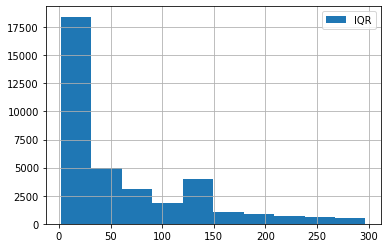

In [31]:
# Подсчитаем границы выбросов по оценкам
median = df['Number of Reviews'].median()
IQR = df['Number of Reviews'].quantile(0.75) - df['Number of Reviews'].quantile(0.25)
perc25 = df['Number of Reviews'].quantile(0.25)
perc75 = df['Number of Reviews'].quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75),
      "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))
df['Number of Reviews'].loc[df['Number of Reviews'].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(
                                                                              label='IQR')

plt.legend()

In [32]:
df['Number of Reviews'].describe()

count    40000.000000
mean       124.825480
std        286.113292
min          2.000000
25%         10.000000
50%         38.000000
75%        124.825480
max       9660.000000
Name: Number of Reviews, dtype: float64

In [33]:
df['Number of Reviews'].value_counts()

124.82548     2543
2.00000       1916
3.00000       1636
4.00000       1370
5.00000       1181
              ... 
2123.00000       1
1633.00000       1
1480.00000       1
1924.00000       1
1383.00000       1
Name: Number of Reviews, Length: 1460, dtype: int64

NormaltestResult(statistic=33715.39039185855, pvalue=0.0)

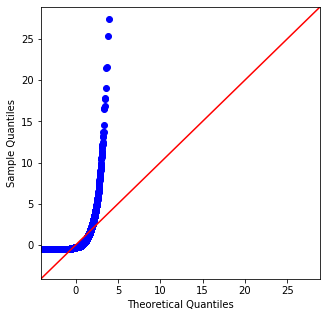

In [34]:
#   Проверим нормальность распределения оценок
fig,ax = plt.subplots(figsize = (5,5))
ax = sm.qqplot(df['Number of Reviews'][df['Number of Reviews']>20],fit = True, line ='45', ax=ax)
stats.normaltest(df['Number of Reviews'][df['Number of Reviews']>20])

Резюме - Признак содержал пропуски которые мы заменили на среднее значение. Так же присутствуют выбросы, но их пока не будем удалятьКак видим распределение очень странное, такое возможно из-за накрутки отзывов. К сожалению у меня не хватает навыком что бы сделать из этого какие то выводы ¯\_(ツ)_/¯.  

###  3.2 Обработаем колонку Reviews

In [35]:
# Разабъём колонку Reviews на колонки с ревью и с датами
df['date_of_Review'] = df['Reviews'].str.findall('\d+/\d+/\d+')
df['data_first'] = df['date_of_Review'].apply(lambda x: pd.to_datetime(x).min())
df['data_last'] = df['date_of_Review'].apply(lambda x: pd.to_datetime(x).max())
del df['date_of_Review']

In [36]:
#Уберём лишние знаки 
df['Reviews'] = [x.split(']')[0] for x in df['Reviews']]
df['Reviews'] = df['Reviews'].str.replace('[','')

In [37]:
# Пропуски в столбцах 'Deta Reviews' и 'Last Review' заполним средними значениями
df['data_first'] = df['data_first'].fillna(df['data_first'].mean()).dt.date
df['data_last'] = df['data_last'].fillna(df['data_last'].mean()).dt.date

In [38]:
#Добавим колонку с разницай между датами
df['difference datas'] = df['data_last'] - df['data_first']
df['difference datas'] = df['difference datas'] .astype('timedelta64[D]')
df.head(3)

Restaurant_id       City  \
0       id_5569      Paris   
1       id_1535  Stockholm   
2        id_352     London   

                                                                  Cuisine Style  \
0                                                 European,French,International   
1                                                                         Other   
2  Japanese,Sushi,Asian,Grill,VegetarianFriendly,VeganOptions,GlutenFreeOptions   

   Ranking  Rating  Price Range  Number of Reviews  \
0   5570.0     3.5            2              194.0   
1   1537.0     4.0            2               10.0   
2    353.0     4.5            3              688.0   

                                                   Reviews  \
0  'Good food at your doorstep', 'A good hotel restaurant'   
1              'Unique cuisine', 'Delicious Nepalese food'   
2               'Catch up with friends', 'Not exceptional'   

                                                                         URL_TA  \
0   /Restaurant_Review-g187147-d1912643-Reviews-R_Yves-Paris_Ile_de_France.html   
1       /Restaurant_Review-g189852-d7992032-Reviews-Buddha_Nepal-Stockholm.html   
2  /Restaurant_Review-g186338-d8632781-Reviews-ROKA_Mayfair-London_England.html   

     ID_TA  NaN_Price Range  NAN_Cuisine Style  Cuisine Count  Unique Cuisine  \
0  1912643              0.0                0.0              3               0   
1  7992032              1.0                1.0              1               0   
2  8632781              0.0                0.0              7               0   

   NAN_Number of Reviews  NoR nan  data_first   data_last  difference datas  
0                    0.0    False  2017-11-20  2017-12-31              41.0  
1                    0.0    False  2016-06-19  2017-07-06             382.0  
2                    0.0    False  2018-01-06  2018-01-08               2.0

count    40000.000000
mean       122.382225
std        193.406807
min          0.000000
25%         13.000000
50%         76.000000
75%        122.000000
max       3207.000000
Name: difference datas, dtype: float64

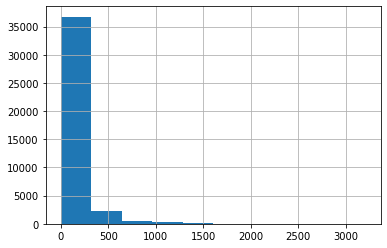

In [39]:
# проверим полученный критерий
df['difference datas'].hist()
df['difference datas'].describe()

Резюме - Reviews была разбита на колонки с текстом и датамаи, был сгенирирован новый признак разница между датами. Как видно из графика разница между отзывами примерно одинаковая.

# 4. Обработаем колонку City

In [40]:
# Посчитаем сколько ресторанов в каждом городе
count_restoraunts_city = pd.DataFrame(df.groupby(by='City').Restaurant_id.nunique()).sort_values(
    'Restaurant_id', ascending=False)
# переименуем одну из колонок, что бы название соответствовало содержимому
count_restoraunts_city.rename(
    columns={'Restaurant_id': 'count_restoraunts'}, inplace=True)
# Добавим индекс
count_restoraunts_city.reset_index(inplace = True)
count_restoraunts_city.head(3)

City  count_restoraunts
0  London               5757
1   Paris               4897
2  Madrid               3108

In [41]:
# Соеденим два датафрейма по условию City
df = df.merge(count_restoraunts_city, on=["City"])
df.head(3)

Restaurant_id   City                  Cuisine Style  Ranking  Rating  \
0       id_5569  Paris  European,French,International   5570.0     3.5   
1      id_10057  Paris                          Other  10059.0     4.5   
2      id_11291  Paris                         French  11293.0     4.5   

   Price Range  Number of Reviews  \
0            2              194.0   
1            2                4.0   
2            2               10.0   

                                                   Reviews  \
0  'Good food at your doorstep', 'A good hotel restaurant'   
1                                               'Fab Food'   
2          'A relaxing dinner in a very personal atmos...'   

                                                                                  URL_TA  \
0            /Restaurant_Review-g187147-d1912643-Reviews-R_Yves-Paris_Ile_de_France.html   
1        /Restaurant_Review-g187147-d2040769-Reviews-Le_Paradis-Paris_Ile_de_France.html   
2  /Restaurant_Review-g187147-d3543081-Reviews-La_Cave_Marcadet-Paris_Ile_de_France.html   

     ID_TA  NaN_Price Range  NAN_Cuisine Style  Cuisine Count  Unique Cuisine  \
0  1912643              0.0                0.0              3               0   
1  2040769              1.0                1.0              1               0   
2  3543081              0.0                0.0              1               0   

   NAN_Number of Reviews  NoR nan  data_first   data_last  difference datas  \
0                    0.0    False  2017-11-20  2017-12-31              41.0   
1                    0.0    False  2011-08-20  2011-08-20               0.0   
2                    0.0    False  2015-03-08  2015-03-08               0.0   

   count_restoraunts  
0               4897  
1               4897  
2               4897

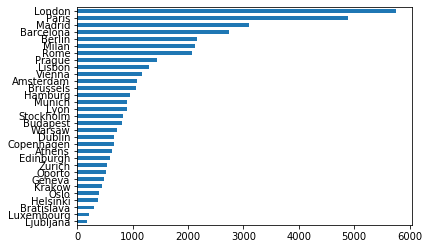

In [42]:
# Посмотрим на распределение ресторанов по городам
df['City'].value_counts(ascending=True).plot(kind='barh')

count    40000.000000
mean      2566.000000
std       1862.235407
min        183.000000
25%        893.000000
50%       2133.000000
75%       4897.000000
max       5757.000000
Name: count_restoraunts, dtype: float64

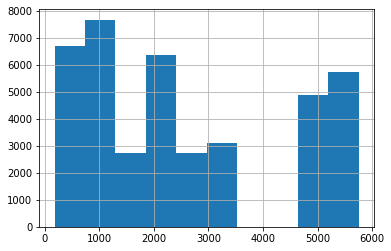

In [43]:
# проверим полученный критерий
df.count_restoraunts.hist()
df.count_restoraunts.describe()

Резюме - В City отсутсвуют пропуски. Так же был сгенерирован новый признак количество ресторанов в  городе. 

 # 5. Обработаем ранг ресторанов

## 5.1 Обработаем колонку Rating

In [44]:
# Добавим признак относительный рейтинг
#df['Relative Rating'] = df['Rating'] / df['count_restoraunts']
# df.head(3)

С данным признаком MAE  получаеться примерно 0.04, но данный способ не релевантен, так как этот признак есть прямая производная от рейтинга конкретного ресторана.

In [45]:
# Найдем средний рейтинг ресторанов в городе
Mean_Rating_City = pd.DataFrame(df.groupby(by = 'City').Rating.mean()).sort_values('Rating', ascending = False)
# переименуем колонки, что бы название соответствовало содержимому
Mean_Rating_City.rename(
    columns={'Rating': 'Mean Rating City'}, inplace=True)

# Добавим индекс
Mean_Rating_City.reset_index(inplace = True)
Mean_Rating_City.head(3)

City  Mean Rating City
0    Rome          4.230269
1  Athens          4.230096
2  Oporto          4.178363

In [46]:
# Округлим значения до десятичных знаков, так как  все значения у нас с точностью до 1 знака
Mean_Rating_City['Mean Rating City']= Mean_Rating_City['Mean Rating City'].round(1)
Mean_Rating_City

City  Mean Rating City
0         Rome               4.2
1       Athens               4.2
2       Oporto               4.2
3       Krakow               4.1
4    Amsterdam               4.1
5       Berlin               4.1
6    Ljubljana               4.1
7     Budapest               4.1
8       Warsaw               4.1
9    Edinburgh               4.1
10      Vienna               4.1
11      Dublin               4.1
12      Munich               4.0
13      Lisbon               4.0
14      Zurich               4.0
15      Prague               4.0
16     Hamburg               4.0
17  Copenhagen               4.0
18  Bratislava               4.0
19      Geneva               4.0
20   Barcelona               4.0
21      London               4.0
22        Lyon               3.9
23    Helsinki               3.9
24       Paris               3.9
25  Luxembourg               3.9
26    Brussels               3.9
27        Oslo               3.9
28   Stockholm               3.9
29       Milan               3.8
30      Madrid               3.8

In [47]:
# Соеденим два датафрейма по условию City
df = df.merge(Mean_Rating_City, on=["City"])
df.head(3)

Restaurant_id   City                  Cuisine Style  Ranking  Rating  \
0       id_5569  Paris  European,French,International   5570.0     3.5   
1      id_10057  Paris                          Other  10059.0     4.5   
2      id_11291  Paris                         French  11293.0     4.5   

   Price Range  Number of Reviews  \
0            2              194.0   
1            2                4.0   
2            2               10.0   

                                                   Reviews  \
0  'Good food at your doorstep', 'A good hotel restaurant'   
1                                               'Fab Food'   
2          'A relaxing dinner in a very personal atmos...'   

                                                                                  URL_TA  \
0            /Restaurant_Review-g187147-d1912643-Reviews-R_Yves-Paris_Ile_de_France.html   
1        /Restaurant_Review-g187147-d2040769-Reviews-Le_Paradis-Paris_Ile_de_France.html   
2  /Restaurant_Review-g187147-d3543081-Reviews-La_Cave_Marcadet-Paris_Ile_de_France.html   

     ID_TA  ...  NAN_Cuisine Style  Cuisine Count  Unique Cuisine  \
0  1912643  ...                0.0              3               0   
1  2040769  ...                1.0              1               0   
2  3543081  ...                0.0              1               0   

   NAN_Number of Reviews  NoR nan  data_first   data_last difference datas  \
0                    0.0    False  2017-11-20  2017-12-31             41.0   
1                    0.0    False  2011-08-20  2011-08-20              0.0   
2                    0.0    False  2015-03-08  2015-03-08              0.0   

   count_restoraunts  Mean Rating City  
0               4897               3.9  
1               4897               3.9  
2               4897               3.9  

[3 rows x 21 columns]

## 5.2 Обработаем колонку Ranking

In [48]:
# Добавим признак относительный рейтинг
df['Relative Ranking'] = df['Ranking'] / df['count_restoraunts']
df.head(3)

Restaurant_id   City                  Cuisine Style  Ranking  Rating  \
0       id_5569  Paris  European,French,International   5570.0     3.5   
1      id_10057  Paris                          Other  10059.0     4.5   
2      id_11291  Paris                         French  11293.0     4.5   

   Price Range  Number of Reviews  \
0            2              194.0   
1            2                4.0   
2            2               10.0   

                                                   Reviews  \
0  'Good food at your doorstep', 'A good hotel restaurant'   
1                                               'Fab Food'   
2          'A relaxing dinner in a very personal atmos...'   

                                                                                  URL_TA  \
0            /Restaurant_Review-g187147-d1912643-Reviews-R_Yves-Paris_Ile_de_France.html   
1        /Restaurant_Review-g187147-d2040769-Reviews-Le_Paradis-Paris_Ile_de_France.html   
2  /Restaurant_Review-g187147-d3543081-Reviews-La_Cave_Marcadet-Paris_Ile_de_France.html   

     ID_TA  ...  Cuisine Count  Unique Cuisine  NAN_Number of Reviews  \
0  1912643  ...              3               0                    0.0   
1  2040769  ...              1               0                    0.0   
2  3543081  ...              1               0                    0.0   

   NoR nan  data_first   data_last difference datas count_restoraunts  \
0    False  2017-11-20  2017-12-31             41.0              4897   
1    False  2011-08-20  2011-08-20              0.0              4897   
2    False  2015-03-08  2015-03-08              0.0              4897   

   Mean Rating City  Relative Ranking  
0               3.9          1.137431  
1               3.9          2.054115  
2               3.9          2.306106  

[3 rows x 22 columns]

In [49]:
# Найдем средний рейтинг ресторанов в городе
Mean_Ranking_City = pd.DataFrame(df.groupby(by = 'City').Ranking.mean()).sort_values('Ranking', ascending = False)
# переименуем колонки, что бы название соответствовало содержимому
Mean_Ranking_City.rename(
    columns={'Ranking': 'Mean Ranking City'}, inplace=True)
Mean_Ranking_City.head(3)

Mean Ranking City
City                     
London        8198.461873
Paris         6933.012048
Madrid        4388.423102

In [50]:
# Округлим значения до десятичных знаков, так как  все значения у нас с точностью до 1 знака
Mean_Ranking_City['Mean Ranking City']= Mean_Ranking_City['Mean Ranking City'].round(1)
Mean_Ranking_City.head(3)

Mean Ranking City
City                     
London             8198.5
Paris              6933.0
Madrid             4388.4

In [51]:
# Соеденим два датафрейма по условию City
df = df.merge(Mean_Ranking_City, on=["City"])
df.head(3)

Restaurant_id   City                  Cuisine Style  Ranking  Rating  \
0       id_5569  Paris  European,French,International   5570.0     3.5   
1      id_10057  Paris                          Other  10059.0     4.5   
2      id_11291  Paris                         French  11293.0     4.5   

   Price Range  Number of Reviews  \
0            2              194.0   
1            2                4.0   
2            2               10.0   

                                                   Reviews  \
0  'Good food at your doorstep', 'A good hotel restaurant'   
1                                               'Fab Food'   
2          'A relaxing dinner in a very personal atmos...'   

                                                                                  URL_TA  \
0            /Restaurant_Review-g187147-d1912643-Reviews-R_Yves-Paris_Ile_de_France.html   
1        /Restaurant_Review-g187147-d2040769-Reviews-Le_Paradis-Paris_Ile_de_France.html   
2  /Restaurant_Review-g187147-d3543081-Reviews-La_Cave_Marcadet-Paris_Ile_de_France.html   

     ID_TA  ...  Unique Cuisine  NAN_Number of Reviews  NoR nan  data_first  \
0  1912643  ...               0                    0.0    False  2017-11-20   
1  2040769  ...               0                    0.0    False  2011-08-20   
2  3543081  ...               0                    0.0    False  2015-03-08   

    data_last  difference datas count_restoraunts Mean Rating City  \
0  2017-12-31              41.0              4897              3.9   
1  2011-08-20               0.0              4897              3.9   
2  2015-03-08               0.0              4897              3.9   

   Relative Ranking  Mean Ranking City  
0          1.137431             6933.0  
1          2.054115             6933.0  
2          2.306106             6933.0  

[3 rows x 23 columns]

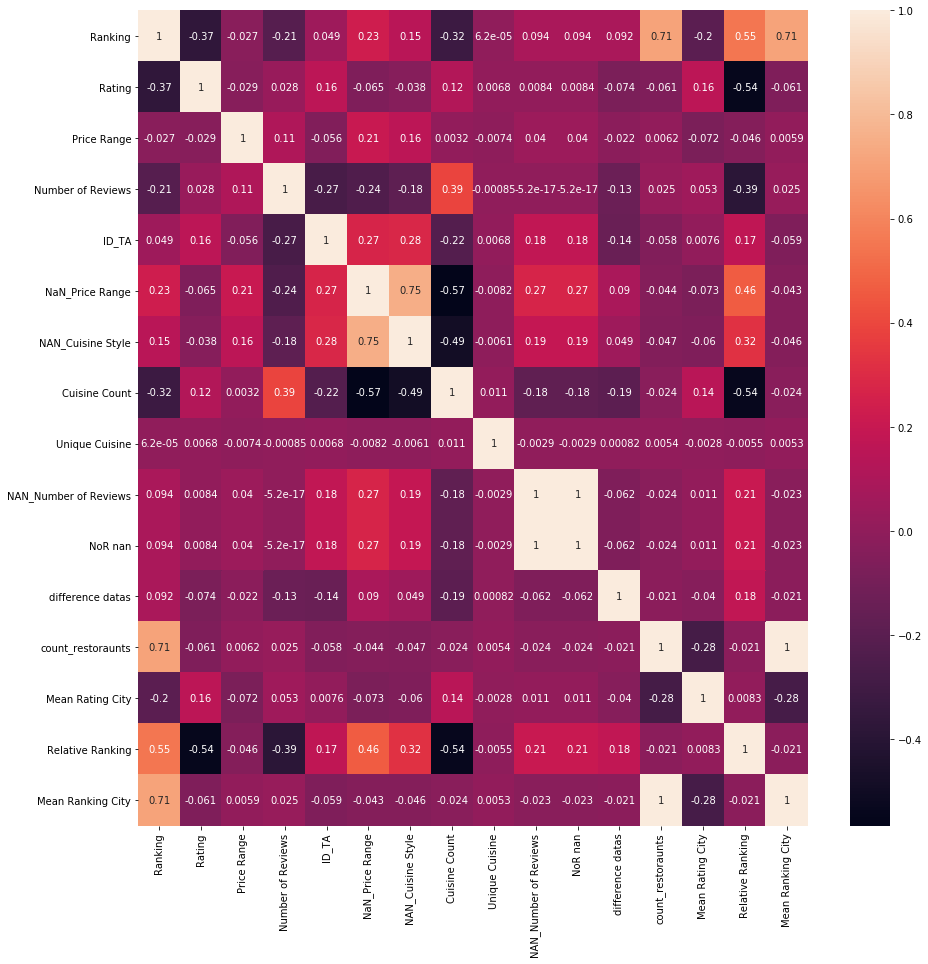

In [52]:
# Проверим корреляцию признаков
C = df.corr(method='pearson')
plt.figure(figsize = (15, 15)) # размер графика
sns.heatmap(data = C, annot = True)
# Видно, что 'GDP' очень сильно скоррелирован с 'Population'

# 6. Обработаем данные из внешних источнтков

## 6.1 Добавим данные о населении страны

In [53]:
# Создадим словарь с данными о каждом городе, в котором собрана информация о:
# названии страны (анг.)[0], названии страны (рус.)[1], статусе столицы [2], населении города [3], количестве туристов [5].
# Названия стран и городов пригодятся в дальнейшем для парсинга данных.
# Население городов и количество туристов в стране изначально парсил по таблицам ООН и Международной туристической организации,
# но в таком случае очень долго обрабатыватся таблицы, так что добавил в этот словарь.

cities_data = {
    'Paris': ['France', 'Франция', True, 2206488, 89322],
    'Stockholm': ['Sweden', 'Швеция', True, 789024, 10522],
    'London': ['United Kingdom', 'Великобритания', True, 8135667, 36316],
    'Berlin': ['Germany', 'Германия', True, 3613495, 38881],
    'Munich': ['Germany', 'Германия', False, 1456039, 38881],
    'Oporto': ['Portugal', 'Португалия', False, 214353, 16186],
    'Milan': ['Italy', 'Италия', False, 1358871, 61567],
    'Bratislava': ['Slovakia', 'Словакия', True, 427744, 7620],
    'Vienna': ['Austria', 'Австрия', True, 1888776, 30816],
    'Rome': ['Italy', 'Италия', True, 2873147, 61567],
    'Barcelona': ['Spain', 'Испания', False, 1620576, 82773],
    'Madrid': ['Spain', 'Испания', True, 3203157, 82773],
    'Dublin': ['Ireland', 'Ирландия', True, 544107, 10926],
    'Brussels': ['Belgium', 'Бельгия', True, 174383, 9119],
    'Zurich': ['Switzerland', 'Швейцария', False, 415367, 11715],
    'Warsaw': ['Poland', 'Польша', True, 1754511, 19622],
    'Budapest': ['Hungary', 'Венгрия', True, 1751219, 17552],
    'Copenhagen': ['Denmark', 'Дания', True, 616098, 12749],
    'Amsterdam': ['Netherlands', 'Нидерланды', True, 821752, 18780],
    'Lyon': ['France', 'Франция', False, 513275, 89322],
    'Hamburg': ['Germany', 'Германия', False, 1830584, 38881],
    'Lisbon': ['Portugal', 'Португалия', True, 505526, 16186],
    'Prague': ['Czech Republic (Czechia)', 'Чехия', True, 1294513, 13665],
    'Oslo': ['Norway', 'Норвегия', True, 634293, 5688],
    'Helsinki': ['Finland', 'Финляндия', True, 639227, 3224],
    'Edinburgh': ['United Kingdom', 'Великобритания', False, 482005, 36316],
    'Geneva': ['Switzerland', 'Швейцария', False, 201818, 11715],
    'Ljubljana': ['Slovenia', 'Словения', True, 279650, 4425],
    'Athens': ['Greece', 'Греция', True, 664046, 30123],
    'Luxembourg': ['Luxembourg', 'Люксембург', True, 116323, 1018],
    'Krakow': ['Poland', 'Польша', False, 759104, 19622]
}

In [54]:
# Данные о населении страны нашел на worldometers.info
url = 'https://www.worldometers.info/world-population/population-by-country/'
response = requests.get(url)
page = BeautifulSoup(requests.get(url, headers={'User-Agent': 'Mozilla/5.0'}).text, 'html.parser')

In [55]:
# Загружаем таблицу
all_blocks = page.find_all('div', class_='table-responsive')
data_html = all_blocks[0].find('table')
population_data = pd.read_html(str(data_html))[0]  
population_data.head(3)

# Country (or dependency)  Population (2020) Yearly Change  Net Change  \
0  1                   China         1439323776        0.39 %     5540090   
1  2                   India         1380004385        0.99 %    13586631   
2  3           United States          331002651        0.59 %     1937734   

   Density (P/Km²)  Land Area (Km²)  Migrants (net) Fert. Rate Med. Age  \
0              153          9388211       -348399.0        1.7       38   
1              464          2973190       -532687.0        2.2       28   
2               36          9147420        954806.0        1.8       38   

  Urban Pop % World Share  
0        61 %     18.47 %  
1        35 %     17.70 %  
2        83 %      4.25 %

In [56]:
# Создаю функцию, извлекающую данные из таблицы по названию города
def Population_Data(city):
    df = {}
    # В таблице приведены данные для страны, в исследуемом ДФ приведены города
    # Название страны получим используюя ранее созданный словарь cities_data
    country = cities_data[city][0]
    data = population_data[population_data['Country (or dependency)'] == country]
    df[country] = [data['Population (2020)'].values[0], # Население
                   data['Density (P/Km²)'].values[0],  # Плотность населения
                   float(data['Med. Age'].values[0]), # Медианный возраст населения
                   float(data['Urban Pop %'].values[0][:-2])] # Урбанизация
    return df

population_df = {}
for city in cities_data:
    if cities_data[city][0] not in population_df:
        population_df.update(Population_Data(city))
population_df

{'France': [65273511, 119, 42.0, 82.0],
 'Sweden': [10099265, 25, 41.0, 88.0],
 'United Kingdom': [67886011, 281, 40.0, 83.0],
 'Germany': [83783942, 240, 46.0, 76.0],
 'Portugal': [10196709, 111, 46.0, 66.0],
 'Italy': [60461826, 206, 47.0, 69.0],
 'Slovakia': [5459642, 114, 41.0, 54.0],
 'Austria': [9006398, 109, 43.0, 57.0],
 'Spain': [46754778, 94, 45.0, 80.0],
 'Ireland': [4937786, 72, 38.0, 63.0],
 'Belgium': [11589623, 383, 42.0, 98.0],
 'Switzerland': [8654622, 219, 43.0, 74.0],
 'Poland': [37846611, 124, 42.0, 60.0],
 'Hungary': [9660351, 107, 43.0, 72.0],
 'Denmark': [5792202, 137, 42.0, 88.0],
 'Netherlands': [17134872, 508, 43.0, 92.0],
 'Czech Republic (Czechia)': [10708981, 139, 43.0, 74.0],
 'Norway': [5421241, 15, 40.0, 83.0],
 'Finland': [5540720, 18, 43.0, 86.0],
 'Slovenia': [2078938, 103, 45.0, 55.0],
 'Greece': [10423054, 81, 46.0, 85.0],
 'Luxembourg': [625978, 242, 40.0, 88.0]}

In [57]:
# Добавляем новые параметры в ДФ
df['Population'] = df['City'].apply(lambda x: population_df[cities_data[x][0]][0])
df['Density'] = df['City'].apply(lambda x: population_df[cities_data[x][0]][1])
df['Med. Age'] = df['City'].apply(lambda x: population_df[cities_data[x][0]][2])
df['Urban Pop. %'] = df['City'].apply(lambda x: population_df[cities_data[x][0]][3])
df.head(3)

Restaurant_id   City                  Cuisine Style  Ranking  Rating  \
0       id_5569  Paris  European,French,International   5570.0     3.5   
1      id_10057  Paris                          Other  10059.0     4.5   
2      id_11291  Paris                         French  11293.0     4.5   

   Price Range  Number of Reviews  \
0            2              194.0   
1            2                4.0   
2            2               10.0   

                                                   Reviews  \
0  'Good food at your doorstep', 'A good hotel restaurant'   
1                                               'Fab Food'   
2          'A relaxing dinner in a very personal atmos...'   

                                                                                  URL_TA  \
0            /Restaurant_Review-g187147-d1912643-Reviews-R_Yves-Paris_Ile_de_France.html   
1        /Restaurant_Review-g187147-d2040769-Reviews-Le_Paradis-Paris_Ile_de_France.html   
2  /Restaurant_Review-g187147-d3543081-Reviews-La_Cave_Marcadet-Paris_Ile_de_France.html   

     ID_TA  ...   data_last  difference datas  count_restoraunts  \
0  1912643  ...  2017-12-31              41.0               4897   
1  2040769  ...  2011-08-20               0.0               4897   
2  3543081  ...  2015-03-08               0.0               4897   

   Mean Rating City  Relative Ranking  Mean Ranking City Population Density  \
0               3.9          1.137431             6933.0   65273511     119   
1               3.9          2.054115             6933.0   65273511     119   
2               3.9          2.306106             6933.0   65273511     119   

   Med. Age  Urban Pop. %  
0      42.0          82.0  
1      42.0          82.0  
2      42.0          82.0  

[3 rows x 27 columns]

In [58]:
df['Capital'] = df['City'].apply(lambda x: cities_data[x][2])
df.head(3)

Restaurant_id   City                  Cuisine Style  Ranking  Rating  \
0       id_5569  Paris  European,French,International   5570.0     3.5   
1      id_10057  Paris                          Other  10059.0     4.5   
2      id_11291  Paris                         French  11293.0     4.5   

   Price Range  Number of Reviews  \
0            2              194.0   
1            2                4.0   
2            2               10.0   

                                                   Reviews  \
0  'Good food at your doorstep', 'A good hotel restaurant'   
1                                               'Fab Food'   
2          'A relaxing dinner in a very personal atmos...'   

                                                                                  URL_TA  \
0            /Restaurant_Review-g187147-d1912643-Reviews-R_Yves-Paris_Ile_de_France.html   
1        /Restaurant_Review-g187147-d2040769-Reviews-Le_Paradis-Paris_Ile_de_France.html   
2  /Restaurant_Review-g187147-d3543081-Reviews-La_Cave_Marcadet-Paris_Ile_de_France.html   

     ID_TA  ...  difference datas  count_restoraunts  Mean Rating City  \
0  1912643  ...              41.0               4897               3.9   
1  2040769  ...               0.0               4897               3.9   
2  3543081  ...               0.0               4897               3.9   

   Relative Ranking  Mean Ranking City  Population Density Med. Age  \
0          1.137431             6933.0    65273511     119     42.0   
1          2.054115             6933.0    65273511     119     42.0   
2          2.306106             6933.0    65273511     119     42.0   

   Urban Pop. %  Capital  
0          82.0     True  
1          82.0     True  
2          82.0     True  

[3 rows x 28 columns]

In [59]:
# Дополняю ДФ данными о населении города из словаря cities_data
df['City Pop.'] = df['City'].apply(lambda x: cities_data[x][3])
df.head(3)

Restaurant_id   City                  Cuisine Style  Ranking  Rating  \
0       id_5569  Paris  European,French,International   5570.0     3.5   
1      id_10057  Paris                          Other  10059.0     4.5   
2      id_11291  Paris                         French  11293.0     4.5   

   Price Range  Number of Reviews  \
0            2              194.0   
1            2                4.0   
2            2               10.0   

                                                   Reviews  \
0  'Good food at your doorstep', 'A good hotel restaurant'   
1                                               'Fab Food'   
2          'A relaxing dinner in a very personal atmos...'   

                                                                                  URL_TA  \
0            /Restaurant_Review-g187147-d1912643-Reviews-R_Yves-Paris_Ile_de_France.html   
1        /Restaurant_Review-g187147-d2040769-Reviews-Le_Paradis-Paris_Ile_de_France.html   
2  /Restaurant_Review-g187147-d3543081-Reviews-La_Cave_Marcadet-Paris_Ile_de_France.html   

     ID_TA  ...  count_restoraunts  Mean Rating City  Relative Ranking  \
0  1912643  ...               4897               3.9          1.137431   
1  2040769  ...               4897               3.9          2.054115   
2  3543081  ...               4897               3.9          2.306106   

   Mean Ranking City  Population  Density Med. Age Urban Pop. %  Capital  \
0             6933.0    65273511      119     42.0         82.0     True   
1             6933.0    65273511      119     42.0         82.0     True   
2             6933.0    65273511      119     42.0         82.0     True   

   City Pop.  
0    2206488  
1    2206488  
2    2206488  

[3 rows x 29 columns]

In [60]:
# Находим данные о размере ВВП стран по паритету покупательной способности
url_gdp = 'https://nonews.co/directory/lists/countries/gdp-ppp'
page = BeautifulSoup(requests.get(url_gdp, headers={'User-Agent': 'Mozilla/5.0'}).text, 'html.parser')

In [61]:
# Извлекаем таблицу со страницы сайта
all_blocks = page.find_all('div', class_='tab_widget wp_shortcodes_tabs')
data_html = all_blocks[0].find('table')
gdp_data = pd.read_html(str(data_html))[0]
gdp_data.head(3)

№ Страна      ВВП (дол. США)
0  1  Китай  24 273 360 028 006
1  2    США  20 936 600 000 000
2  3  Индия   8 907 027 654 120

In [62]:
# Создаю функцию для извлечения данных из таблицы по наименованию города
def GDP_Data(city):
    country = cities_data[city][1]
    data = gdp_data[gdp_data['Страна'] == country]
    gdp = data['ВВП (дол. США)'].values[0]
    return int(''.join([x for x in (gdp).split()]))

In [63]:
# Добавляю параметр ВВП ('GDP') и ВВП на душу населения рассчитываю ('GDP/Pop')
df['GDP'] = df['City'].apply(lambda x: GDP_Data(x))
df['GDP/Pop.'] = df['GDP'] / df['Population']
df.head(3)

Restaurant_id   City                  Cuisine Style  Ranking  Rating  \
0       id_5569  Paris  European,French,International   5570.0     3.5   
1      id_10057  Paris                          Other  10059.0     4.5   
2      id_11291  Paris                         French  11293.0     4.5   

   Price Range  Number of Reviews  \
0            2              194.0   
1            2                4.0   
2            2               10.0   

                                                   Reviews  \
0  'Good food at your doorstep', 'A good hotel restaurant'   
1                                               'Fab Food'   
2          'A relaxing dinner in a very personal atmos...'   

                                                                                  URL_TA  \
0            /Restaurant_Review-g187147-d1912643-Reviews-R_Yves-Paris_Ile_de_France.html   
1        /Restaurant_Review-g187147-d2040769-Reviews-Le_Paradis-Paris_Ile_de_France.html   
2  /Restaurant_Review-g187147-d3543081-Reviews-La_Cave_Marcadet-Paris_Ile_de_France.html   

     ID_TA  ...  Relative Ranking  Mean Ranking City  Population  Density  \
0  1912643  ...          1.137431             6933.0    65273511      119   
1  2040769  ...          2.054115             6933.0    65273511      119   
2  3543081  ...          2.306106             6933.0    65273511      119   

   Med. Age  Urban Pop. % Capital City Pop.            GDP      GDP/Pop.  
0      42.0          82.0    True   2206488  3115307327636  47726.976532  
1      42.0          82.0    True   2206488  3115307327636  47726.976532  
2      42.0          82.0    True   2206488  3115307327636  47726.976532  

[3 rows x 31 columns]

In [64]:
# Добавляю данные о количестве туристов 'Tourism' из словаря cities_data и туристов на душу населения 'Tourism/Pop.'
df['Tourism'] = df['City'].apply(lambda x: cities_data[x][4])
df['Tourism/Pop.'] = df['Tourism'] / df['Population']
df.head(3)

Restaurant_id   City                  Cuisine Style  Ranking  Rating  \
0       id_5569  Paris  European,French,International   5570.0     3.5   
1      id_10057  Paris                          Other  10059.0     4.5   
2      id_11291  Paris                         French  11293.0     4.5   

   Price Range  Number of Reviews  \
0            2              194.0   
1            2                4.0   
2            2               10.0   

                                                   Reviews  \
0  'Good food at your doorstep', 'A good hotel restaurant'   
1                                               'Fab Food'   
2          'A relaxing dinner in a very personal atmos...'   

                                                                                  URL_TA  \
0            /Restaurant_Review-g187147-d1912643-Reviews-R_Yves-Paris_Ile_de_France.html   
1        /Restaurant_Review-g187147-d2040769-Reviews-Le_Paradis-Paris_Ile_de_France.html   
2  /Restaurant_Review-g187147-d3543081-Reviews-La_Cave_Marcadet-Paris_Ile_de_France.html   

     ID_TA  ...  Population  Density  Med. Age  Urban Pop. %  Capital  \
0  1912643  ...    65273511      119      42.0          82.0     True   
1  2040769  ...    65273511      119      42.0          82.0     True   
2  3543081  ...    65273511      119      42.0          82.0     True   

   City Pop.            GDP      GDP/Pop.  Tourism  Tourism/Pop.  
0    2206488  3115307327636  47726.976532    89322      0.001368  
1    2206488  3115307327636  47726.976532    89322      0.001368  
2    2206488  3115307327636  47726.976532    89322      0.001368  

[3 rows x 33 columns]

In [65]:
# Добавляем признак количество людей на ресторан в городе
df['People Per Rest.'] = df['City Pop.'] / df['count_restoraunts']

# Добавляем признак количество туристов на ресторан в городе
df['Tourist Per Rest.'] = df['Tourism'] / df['count_restoraunts']

# Добавляем признак количество отзывов на население города
df['Reviews per C.Pop.'] = df['Number of Reviews'] / df['City Pop.']

# Добавляем признак количество отзывов на количество туристов
df['Reviews per Tourism'] = df['Number of Reviews'] / df['Tourism']

df.head(3)

Restaurant_id   City                  Cuisine Style  Ranking  Rating  \
0       id_5569  Paris  European,French,International   5570.0     3.5   
1      id_10057  Paris                          Other  10059.0     4.5   
2      id_11291  Paris                         French  11293.0     4.5   

   Price Range  Number of Reviews  \
0            2              194.0   
1            2                4.0   
2            2               10.0   

                                                   Reviews  \
0  'Good food at your doorstep', 'A good hotel restaurant'   
1                                               'Fab Food'   
2          'A relaxing dinner in a very personal atmos...'   

                                                                                  URL_TA  \
0            /Restaurant_Review-g187147-d1912643-Reviews-R_Yves-Paris_Ile_de_France.html   
1        /Restaurant_Review-g187147-d2040769-Reviews-Le_Paradis-Paris_Ile_de_France.html   
2  /Restaurant_Review-g187147-d3543081-Reviews-La_Cave_Marcadet-Paris_Ile_de_France.html   

     ID_TA  ...  Capital  City Pop.            GDP      GDP/Pop.  Tourism  \
0  1912643  ...     True    2206488  3115307327636  47726.976532    89322   
1  2040769  ...     True    2206488  3115307327636  47726.976532    89322   
2  3543081  ...     True    2206488  3115307327636  47726.976532    89322   

   Tourism/Pop. People Per Rest. Tourist Per Rest.  Reviews per C.Pop.  \
0      0.001368       450.579538         18.240147            0.000088   
1      0.001368       450.579538         18.240147            0.000002   
2      0.001368       450.579538         18.240147            0.000005   

   Reviews per Tourism  
0             0.002172  
1             0.000045  
2             0.000112  

[3 rows x 37 columns]

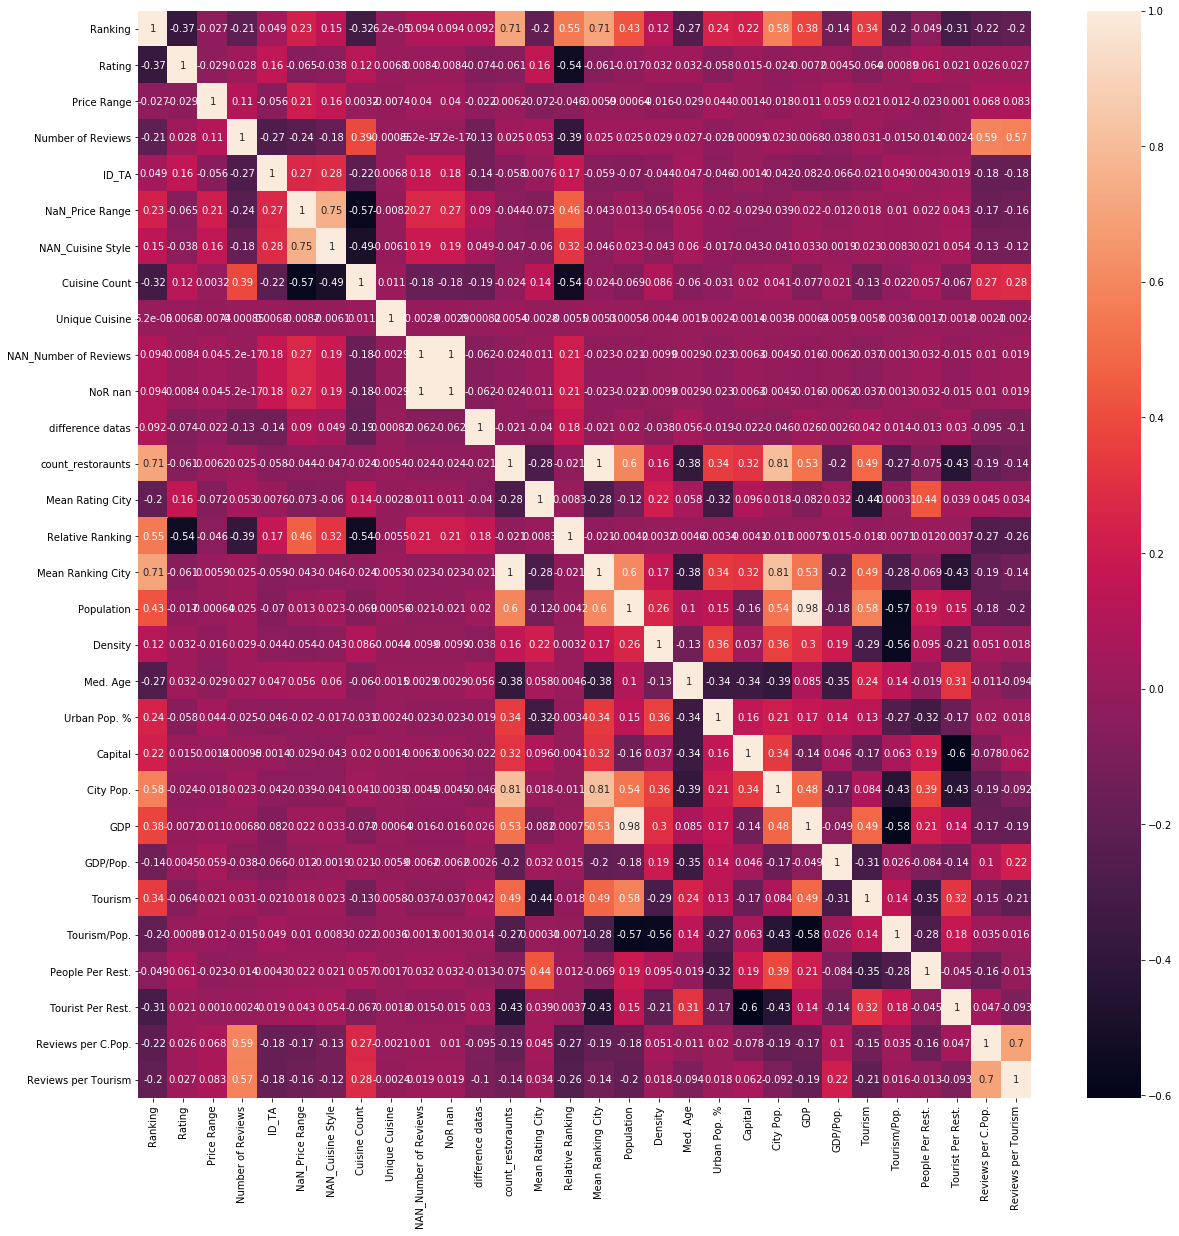

In [66]:
# Проверим корреляцию признаков
C = df.corr(method='pearson')
plt.figure(figsize = (20, 20)) # размер графика
sns.heatmap(data = C, annot = True)
# Видно, что 'GDP' очень сильно скоррелирован с 'Population'


# 7 Проанализируем полученные признаки

## 7.1 Проанализируем кореляцию признаков

In [67]:
# Проверяем перед добавлением dummy-параметров
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Data columns (total 37 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Restaurant_id          40000 non-null  object 
 1   City                   40000 non-null  object 
 2   Cuisine Style          40000 non-null  object 
 3   Ranking                40000 non-null  float64
 4   Rating                 40000 non-null  float64
 5   Price Range            40000 non-null  int64  
 6   Number of Reviews      40000 non-null  float64
 7   Reviews                40000 non-null  object 
 8   URL_TA                 40000 non-null  object 
 9   ID_TA                  40000 non-null  int64  
 10  NaN_Price Range        40000 non-null  float64
 11  NAN_Cuisine Style      40000 non-null  float64
 12  Cuisine Count          40000 non-null  int64  
 13  Unique Cuisine         40000 non-null  int64  
 14  NAN_Number of Reviews  40000 non-null  float64
 15  No

In [68]:
# Проверим корреляцию признаков
C = df.corr(method='pearson')
plt.figure(figsize=(40,40), dpi= 500) # размер графика
sns.heatmap(data = C, annot = True)
# Видно, что 'GDP' очень сильно скоррелирован с 'Population'


In [69]:
# Применим метод PCA для создания нового признака из 'GDP' и 'Population'
from sklearn.decomposition import PCA
A = pd.concat([df['GDP'], df['Population']], axis = 1)
pca = PCA(1)
pca.fit(A)
pca_1 = pca.transform(A)
pca_1

array([[ 1.02202643e+12],
       [ 1.02202643e+12],
       [ 1.02202643e+12],
       ...,
       [-7.92905784e+11],
       [-7.92905784e+11],
       [-7.92905784e+11]])

In [70]:
# Применим метод PCA для создания нового признака из 'count_restoraunts', 'City Pop.' и 'Ranking'
from sklearn.decomposition import PCA
A = pd.concat([df['count_restoraunts'], df['City Pop.'], df['Ranking']], axis = 1)
pca = PCA(1)
pca.fit(A)
pca_2 = pca.transform(A)
pca_2

array([[ -400208.43010582],
       [ -400204.51667039],
       [ -400203.44088975],
       ...,
       [-1847598.94982826],
       [-1847598.49911627],
       [-1847598.36573342]])

In [71]:
# Добавляем полученные параметры к ДФ
df_pca = pd.DataFrame({'PCA_1': list(pca_1), 'PCA_2': list(pca_2)})
df_pca['PCA_1'] = df_pca['PCA_1'].apply(lambda x: x[0])
df_pca['PCA_2'] = df_pca['PCA_2'].apply(lambda x: x[0])
df_pca.head(3)

PCA_1          PCA_2
0  1.022026e+12 -400208.430106
1  1.022026e+12 -400204.516670
2  1.022026e+12 -400203.440890

In [72]:
# Добавляем к ДФ
df = pd.concat([df, df_pca], axis = 1)
df.head(3)

Restaurant_id   City                  Cuisine Style  Ranking  Rating  \
0       id_5569  Paris  European,French,International   5570.0     3.5   
1      id_10057  Paris                          Other  10059.0     4.5   
2      id_11291  Paris                         French  11293.0     4.5   

   Price Range  Number of Reviews  \
0            2              194.0   
1            2                4.0   
2            2               10.0   

                                                   Reviews  \
0  'Good food at your doorstep', 'A good hotel restaurant'   
1                                               'Fab Food'   
2          'A relaxing dinner in a very personal atmos...'   

                                                                                  URL_TA  \
0            /Restaurant_Review-g187147-d1912643-Reviews-R_Yves-Paris_Ile_de_France.html   
1        /Restaurant_Review-g187147-d2040769-Reviews-Le_Paradis-Paris_Ile_de_France.html   
2  /Restaurant_Review-g187147-d3543081-Reviews-La_Cave_Marcadet-Paris_Ile_de_France.html   

     ID_TA  ...            GDP      GDP/Pop.  Tourism  Tourism/Pop.  \
0  1912643  ...  3115307327636  47726.976532    89322      0.001368   
1  2040769  ...  3115307327636  47726.976532    89322      0.001368   
2  3543081  ...  3115307327636  47726.976532    89322      0.001368   

   People Per Rest.  Tourist Per Rest. Reviews per C.Pop. Reviews per Tourism  \
0        450.579538          18.240147           0.000088            0.002172   
1        450.579538          18.240147           0.000002            0.000045   
2        450.579538          18.240147           0.000005            0.000112   

          PCA_1          PCA_2  
0  1.022026e+12 -400208.430106  
1  1.022026e+12 -400204.516670  
2  1.022026e+12 -400203.440890  

[3 rows x 39 columns]

In [73]:
# Добавляем dummy-параметры городов
df_city = pd.get_dummies(df['City'])
df_city.head()

Amsterdam  Athens  Barcelona  Berlin  Bratislava  Brussels  Budapest  \
0          0       0          0       0           0         0         0   
1          0       0          0       0           0         0         0   
2          0       0          0       0           0         0         0   
3          0       0          0       0           0         0         0   
4          0       0          0       0           0         0         0   

   Copenhagen  Dublin  Edinburgh  ...  Munich  Oporto  Oslo  Paris  Prague  \
0           0       0          0  ...       0       0     0      1       0   
1           0       0          0  ...       0       0     0      1       0   
2           0       0          0  ...       0       0     0      1       0   
3           0       0          0  ...       0       0     0      1       0   
4           0       0          0  ...       0       0     0      1       0   

   Rome  Stockholm  Vienna  Warsaw  Zurich  
0     0          0       0       0       0  
1     0          0       0       0       0  
2     0          0       0       0       0  
3     0          0       0       0       0  
4     0          0       0       0       0  

[5 rows x 31 columns]

In [74]:
# Добавляем dummy-параметры ценовой категории
df_price_range = pd.get_dummies(df['Price Range'])
df_price_range.head()

1  2  3
0  0  1  0
1  0  1  0
2  0  1  0
3  0  1  0
4  1  0  0

In [75]:
# Создадим dummy-параметры для кухонь
# cuisine_set - множество типов кухонь, созданное в разделе 6.3
# Создаем функцию для определения наличия кухни в перечне
def Cuisine_dummy(data, cuisine):
    if cuisine in data:
        return 1
    else:
        return 0

# Создаем пустой ДФ, куда сохраним dummy-параметры о кухнях
df_cuisines = pd.DataFrame()

# Добавляем dummy-параметры
for cuisine in count_restoraunts_city['City']:
#    print(cuisine)
#    print(df['Cuisine Style'][0])
#    print(Cuisine_dummy(df['Cuisine Style'][0], cuisine))
    df_cuisines[cuisine] = df['Cuisine Style'].apply(lambda x: Cuisine_dummy(x, cuisine))

df_cuisines.head(3)

London  Paris  Madrid  Barcelona  Berlin  Milan  Rome  Prague  Lisbon  \
0       0      0       0          0       0      0     0       0       0   
1       0      0       0          0       0      0     0       0       0   
2       0      0       0          0       0      0     0       0       0   

   Vienna  ...  Edinburgh  Zurich  Oporto  Geneva  Krakow  Oslo  Helsinki  \
0       0  ...          0       0       0       0       0     0         0   
1       0  ...          0       0       0       0       0     0         0   
2       0  ...          0       0       0       0       0     0         0   

   Bratislava  Luxembourg  Ljubljana  
0           0           0          0  
1           0           0          0  
2           0           0          0  

[3 rows x 31 columns]

In [76]:
# Объединяем в один ДФ
df_ml = pd.concat([df, df_city, df_cuisines, df_price_range], axis = 1)
df_ml.head(3)

Restaurant_id   City                  Cuisine Style  Ranking  Rating  \
0       id_5569  Paris  European,French,International   5570.0     3.5   
1      id_10057  Paris                          Other  10059.0     4.5   
2      id_11291  Paris                         French  11293.0     4.5   

   Price Range  Number of Reviews  \
0            2              194.0   
1            2                4.0   
2            2               10.0   

                                                   Reviews  \
0  'Good food at your doorstep', 'A good hotel restaurant'   
1                                               'Fab Food'   
2          'A relaxing dinner in a very personal atmos...'   

                                                                                  URL_TA  \
0            /Restaurant_Review-g187147-d1912643-Reviews-R_Yves-Paris_Ile_de_France.html   
1        /Restaurant_Review-g187147-d2040769-Reviews-Le_Paradis-Paris_Ile_de_France.html   
2  /Restaurant_Review-g187147-d3543081-Reviews-La_Cave_Marcadet-Paris_Ile_de_France.html   

     ID_TA  ...  Geneva  Krakow  Oslo  Helsinki  Bratislava  Luxembourg  \
0  1912643  ...       0       0     0         0           0           0   
1  2040769  ...       0       0     0         0           0           0   
2  3543081  ...       0       0     0         0           0           0   

  Ljubljana  1  2  3  
0         0  0  1  0  
1         0  0  1  0  
2         0  0  1  0  

[3 rows x 104 columns]

In [77]:
# Для воспроизводимости результатов:
random_seed = 42 # Общий параметр для генерации случайных чисел
current_date = pd.to_datetime('18/04/2021') # Общая текущуя дата

In [78]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
from sklearn.model_selection import train_test_split
#X = df_ml.drop(['Restaurant_id', 'City', 'Cuisine Style', 'Rating', 'GDP', 'Population', 'count_restoraunts', 'City Pop.', 'Ranking', 'URL_TA', 'Price Range', 'Reviews', 'data_first', 'data_last'], axis=1)
X = df_ml.drop(['Restaurant_id', 'City', 'Cuisine Style', 'Rating', 'GDP', 'Population', 'City Pop.', 'Ranking', 'URL_TA', 'Price Range', 'Reviews', 'data_first', 'data_last'], axis=1)
y = df_ml['Rating']

# Загружаем специальный инструмент для разбивки:

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=random_seed)

In [79]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100, verbose = 1, n_jobs = -1, random_state = random_seed)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
MAE = metrics.mean_absolute_error(y_test, y_pred)
print('MAE:', MAE)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.5s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


MAE: 0.200758


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.1s finished


In [80]:
# Создадим функцию округления с точность 0.5
def rating_pred(y_pred):
    y = y_pred // 0.25
    if y % 2 == 0:
        return y * 0.25
    else:
        return (y + 1) * 0.25


# Произведем округление
for i in range(len(y_pred)):
    y_pred[i] = rating_pred(y_pred[i])

In [81]:
# Проверим точность определения рейтинга с учетом округления
MAE_round = metrics.mean_absolute_error(y_test, y_pred)
print(f'Достигнуто значение MAE: {MAE_round}')

Достигнуто значение MAE: 0.1722


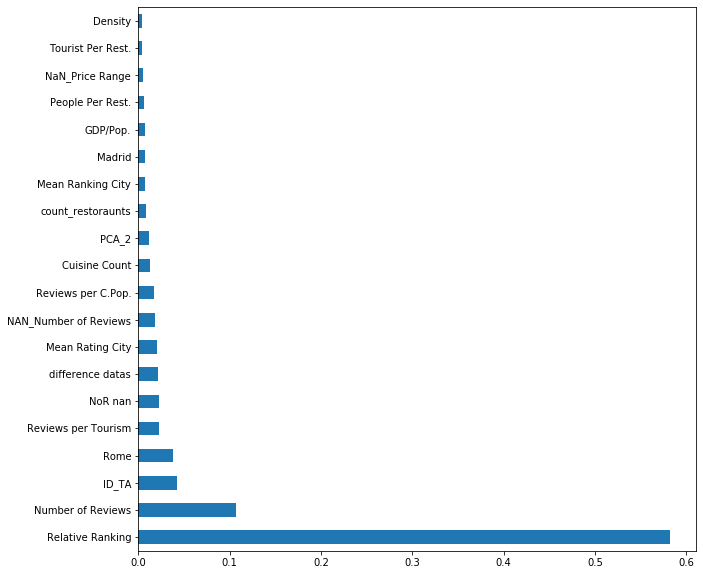

In [82]:
 #Посмотрим на параметры, оказывающие наибольшее влияние на целевую переменную 
plt.figure(figsize = (10,10))
feat_importances = pd.Series(regr.feature_importances_, index = X.columns)
feat_importances.nlargest(20).plot(kind = 'barh')

In [85]:
# Создадим датафрейм с данными для передачи в модель для предсказания рейтингов
df_kt = df_ml.drop(['Restaurant_id', 'City', 'Cuisine Style', 'Rating', 'GDP', 'Population',
                    'City Pop.', 'Ranking', 'URL_TA', 'Price Range', 'Reviews', 'data_first', 'data_last'], axis=1)

In [86]:
df_kt_y_pred = regr.predict(df_kt)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.5s finished


In [87]:
# Произведем округление
for i in range(len(df_kt_y_pred)):
    df_kt_y_pred[i] = rating_pred(df_kt_y_pred[i])

In [88]:
# Создадим датасет конечного результата submission_df
submission_df = pd.DataFrame()

In [89]:
# Запишем в него требуемые данные
submission_df['Restaurant_id'] = df['Restaurant_id']
submission_df['Rating'] = df_kt_y_pred

In [90]:
submission_df

Restaurant_id  Rating
0           id_5569     3.5
1          id_10057     4.5
2          id_11291     4.5
3           id_5459     3.5
4           id_9924     3.5
...             ...     ...
39995        id_651     4.0
39996        id_355     4.0
39997        id_283     4.0
39998        id_800     4.5
39999        id_953     3.5

[40000 rows x 2 columns]

In [91]:
# Сохраним результат в файл
submission_df.to_csv('submission.csv', index = False)